# Hypothesis Testing: Insurance Data

In [1]:
# Imports 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# Loading Data
df = pd.read_csv('Data/insurance - insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Checking for Duplicates and missing values
df.duplicated().sum()

1

In [4]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

In [6]:
df.duplicated().sum()

0

## Q1: Do smokers have higher insurance charges than non-smokers?

Null-Hypothesis: There is no significant difference in charges between smokers and non-smokers

Alternate Hypothesis: There is a significant difference in charges between smokers and non-smokers

In [7]:
# Creating groups for smokers & non-smokers
df['smoker'].value_counts()

no     1063
yes     274
Name: smoker, dtype: int64

In [8]:
smokers_df = df.loc[df['smoker']=='yes'].copy()
non_smokers_df = df.loc[df['smoker']=='no'].copy()
smokers_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
11,62,female,26.29,0,yes,southeast,27808.7251
14,27,male,42.13,0,yes,southeast,39611.7577
19,30,male,35.30,0,yes,southwest,36837.4670
23,34,female,31.92,1,yes,northeast,37701.8768


In [9]:
# Defining features of interest
smokers_charges = smokers_df['charges']
non_smokers_charges = non_smokers_df['charges']

In [10]:
# Checking for outliers
smoker_zscores = stats.zscore(smokers_charges)
smoker_outliers = abs(smoker_zscores)>3
np.sum(smoker_outliers)

0

In [11]:
non_smoker_zscores = stats.zscore(non_smokers_charges)
non_smoker_outliers = abs(non_smoker_zscores)>3
np.sum(non_smoker_outliers)

24

In [17]:
# Removing outliers 
non_smokers_charges = non_smokers_charges[(np.abs(stats.zscore(non_smokers_charges)) < 3)]

In [18]:
equal_var_res = stats.levene(smokers_charges, non_smokers_charges)
print(equal_var_res)
print(equal_var_res.pvalue<.05)

LeveneResult(statistic=787.2237971491927, pvalue=2.6998744150545128e-135)
True


In [20]:
# due to us not meeting our assumptions, we'll be running a Welch's T-Test due to unequal variance
ttest_result = stats.ttest_ind(smokers_charges,
                              non_smokers_charges,
                              equal_var=False)
print(ttest_result)
print(ttest_result.pvalue<.05)

Ttest_indResult(statistic=34.73706539258605, pvalue=6.558175557634472e-106)
True


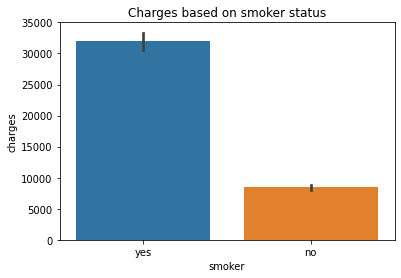

In [23]:
# concatenating previous dataframes and plotting
plotting_df_q1 = pd.concat([smokers_df, non_smokers_df])
ax=sns.barplot(data=plotting_df_q1, x = 'smoker', y='charges')
ax.set(title="Charges based on smoker status");

### Conclusion for Q1

For this hypothesis, with our p value being less than 0.05 we will reject the null hypothesis. "There is a significant difference in charges between smokers and non-smokers"

## Q2: Are men more likely to smoke than women?

Null-Hypothesis: There is no difference in the likeliness to smoke between men and women.

Alternate Hypothesis: Men are more likely to smoke than women.

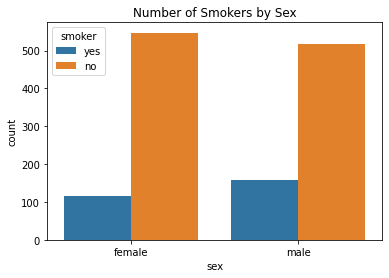

In [29]:
# visualizing smokers by sex 
ax = sns.countplot(data=df, x='sex', hue='smoker')
ax.set_title('Number of Smokers by Sex');

In [30]:
# Getting Contingency Table 

table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,516,159


In [32]:
# Results
smoker_sex_results = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = smoker_sex_results
print(p)
p<.05

0.0062765550120107375


True

### Conclusion for Q2: 

Due to our p value being less than 0.05 we'll be rejecting the null-hypothesis and supporting the alternate hypothesis: "Men are more likely to smoke than women."

## Q3: Do different regions have different charges, on average?

Null-Hypothesis: There is no significant difference in cost between regions.

Alternate Hypothesis: There is a significant difference in cost between regions. 

In [33]:
# creating groups for testing
df['region'].value_counts()

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64

In [34]:
southeast_df = df.loc[df['region']=='southeast'].copy()
southwest_df = df.loc[df['region']=='southwest'].copy()
northeast_df = df.loc[df['region']=='northeast'].copy()
northwest_df = df.loc[df['region']=='northwest'].copy()

In [35]:
# Defining feature of interest
southeast_charges = southeast_df['charges'].mean()
southwest_charges = southwest_df['charges'].mean()
northeast_charges = northeast_df['charges'].mean()
northwest_charges = northwest_df['charges'].mean()

In [52]:
# Checking for outliers 
southeast_outliers = np.abs(stats.zscore(southeast_charges)) > 3
southwest_outliers = np.abs(stats.zscore(southwest_charges)) > 3
northeast_outliers = np.abs(stats.zscore(northeast_charges)) > 3
northwest_outliers = np.abs(stats.zscore(northwest_charges)) > 3

In [54]:
print(southeast_outliers.sum())
print(southwest_outliers.sum())
print(northeast_outliers.sum())
print(northwest_outliers.sum())

2
8
4
7


In [55]:
# Removing outliers
southeast_charges = southeast_charges[(np.abs(stats.zscore(southeast_charges)) < 3)]
southwest_charges = southwest_charges[(np.abs(stats.zscore(southwest_charges)) < 3)]
northeast_charges = northeast_charges[(np.abs(stats.zscore(northeast_charges)) < 3)]
northwest_charges = northwest_charges[(np.abs(stats.zscore(northwest_charges)) < 3)]

In [56]:
# Checking equal variance
region_variance = stats.levene(southeast_charges, southwest_charges, northeast_charges, northwest_charges)
print(region_variance.pvalue<.05)

True


In [ ]:
# Running ANOVA test based on assumptions
